<a href="https://colab.research.google.com/github/paulandrea0/Qualifica-PCA/blob/main/CrossValidation_en_la_Copia_de_PCA_MLPercepton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
df_test_1 = pd.read_csv('/content/drive/MyDrive/Sismos/VT_Z_teste.csv')
df_train_1 = pd.read_csv('/content/drive/MyDrive/Sismos/VT_Z_train.csv')
df_test_2 = pd.read_csv('/content/drive/MyDrive/Sismos/LP_Z_teste.csv')
df_train_2 = pd.read_csv('/content/drive/MyDrive/Sismos/LP_Z_train.csv')
df_test_3 = pd.read_csv('/content/drive/MyDrive/Sismos/TOR_Z_teste.csv')
df_train_3 = pd.read_csv('/content/drive/MyDrive/Sismos/TOR_Z_train.csv')
sismos = pd.read_excel('/content/drive/MyDrive/Sismos/Distribución de datos sísmicos.xlsx')

In [ ]:
sismos.fillna(0, inplace=True)
sismos = sismos.rename(columns={'VTz':'VT seism',
                                   'LPz':'LP seism', 'Tor z':'TOR seism'})

print(sismos.head)
sismos.dtypes

<bound method NDFrame.head of       VT seism     VTn     Vte  LP seism     LPn     LPe  TOR seism    Tor n  \
0         2157  2157.0  2157.0    3000.0  3000.0  3000.0     4672.0   4672.0   
1         2893  2893.0  2893.0    3000.0  3000.0  3000.0     3096.0   3096.0   
2         2207  2207.0  2207.0    3000.0  3000.0  3000.0     7956.0   7956.0   
3         1794  1794.0  1794.0    3000.0  3000.0  3000.0     6507.0   6507.0   
4         1135  1135.0  1135.0    3000.0  3000.0  3000.0    10262.0  10262.0   
...        ...     ...     ...       ...     ...     ...        ...      ...   
1731      2030     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1732      1480     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1733      1347     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1734      1838     0.0     0.0       0.0     0.0     0.0        0.0      0.0   
1735      1449     0.0     0.0       0.0     0.0     0.0        0.0      0.0   

        T

VT seism       int64
VTn          float64
Vte          float64
LP seism     float64
LPn          float64
LPe          float64
TOR seism    float64
Tor n        float64
Tor e        float64
dtype: object

In [ ]:
import seaborn as sns

sis = (sismos['VT seism'], sismos['LP seism'], sismos['TOR seism'])
print(sis)

(0       2157
1       2893
2       2207
3       1794
4       1135
        ... 
1731    2030
1732    1480
1733    1347
1734    1838
1735    1449
Name: VT seism, Length: 1736, dtype: int64, 0       3000.0
1       3000.0
2       3000.0
3       3000.0
4       3000.0
         ...  
1731       0.0
1732       0.0
1733       0.0
1734       0.0
1735       0.0
Name: LP seism, Length: 1736, dtype: float64, 0        4672.0
1        3096.0
2        7956.0
3        6507.0
4       10262.0
         ...   
1731        0.0
1732        0.0
1733        0.0
1734        0.0
1735        0.0
Name: TOR seism, Length: 1736, dtype: float64)


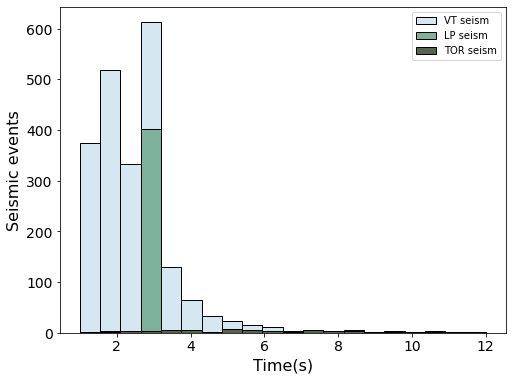

In [ ]:
from seaborn.rcmod import set_palette
import seaborn as sns

sis_segundos = tuple([x/1000.0 for x in sis])  # Convertir a segundos

plt.figure(figsize = (8, 6))
axes = plt.gca()
sns.histplot(sis_segundos, binrange=(1,12), bins=20, multiple="stack", palette=sns.cubehelix_palette(3, start=1.6), kde=False)

plt.ylabel('Seismic events')
plt.xlabel('Time(s)')
# plt.title('Distribution of seismic event duration')

axes.title.set_size(20)
axes.xaxis.label.set_size(16)
axes.yaxis.label.set_size(16)
axes.tick_params(axis='both', labelsize=14)
plt.show()
axes.figure.savefig('Histograma.pdf', dpi=400, format='pdf')

(1480, 13348)
(256, 10993)
(362, 3000)
(40, 3000)
(61, 21494)
(6, 27408)


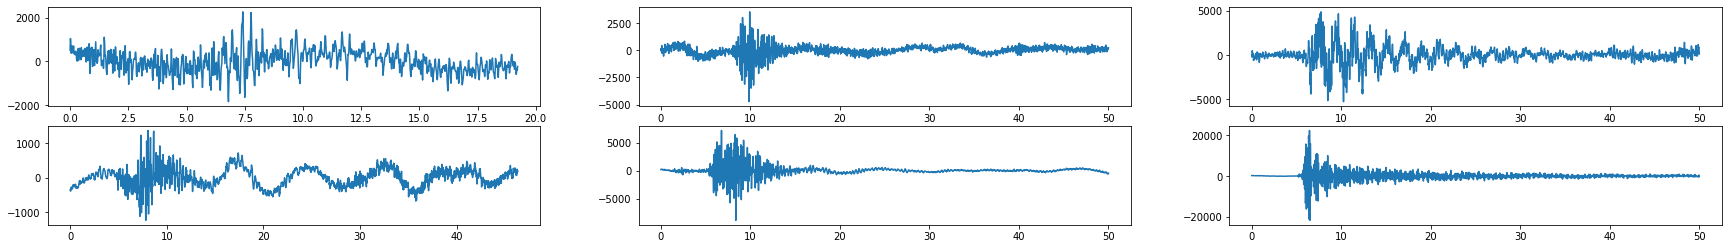

In [ ]:
# Creando función para retirar el offset de los datos en DataFrame
def mean_norma(df_input):
  return df_input.apply(lambda x: (x-x.mean()), axis=1)

df_mean_test_1 = mean_norma(df_test_1) # Señales VT
df_mean_train_1 = mean_norma(df_train_1)
df_mean_test_2 = mean_norma(df_test_2) # Señales LP
df_mean_train_2 = mean_norma(df_train_2)
df_mean_test_3 = mean_norma(df_test_3) # Señales Tor
df_mean_train_3 = mean_norma(df_train_3)

print(df_mean_train_1.shape)
print(df_mean_test_1.shape)
print(df_mean_train_2.shape)
print(df_mean_test_2.shape)
print(df_mean_train_3.shape)
print(df_mean_test_3.shape)

# Convirtiendo el dataframe en array
d_train_1 = df_mean_train_1.values
d_train_1 = d_train_1[:, 0:3000]
d_test_1 = df_mean_test_1.values
d_test_1 = d_test_1[:, 0:3000]

d_train_2 = df_mean_train_2.values
d_train_2 = d_train_2[:, 0:3000]
d_test_2 = df_mean_test_2.values
d_test_2 = d_test_2[:, 0:6000]

d_train_3 = df_mean_train_3.values
d_train_3 = d_train_3[:, 0:3000]
d_test_3 = df_mean_test_3.values
d_test_3 = d_test_3[:, 0:3000]

# Dibujando la señal orioginal
n = 3000
fs = 50 # frecuencia de muestreo
t = np.linspace(0,fs,n)
plt.figure(1, figsize=(30, 4))
plt.subplot(231)
plt.plot(t, d_train_1[60])
plt.subplot(232)
plt.plot(t, d_train_2[18])
plt.subplot(233)
plt.plot(t, d_train_3[38])
plt.subplot(234)
plt.plot(t, d_test_1[44])
plt.subplot(235)
plt.plot(t, d_test_2[34])
plt.subplot(236)
plt.plot(t, d_test_3[4])

(1480, 3000)
(256, 3000)
(362, 3000)
(40, 3000)
(61, 3000)
(6, 3000)


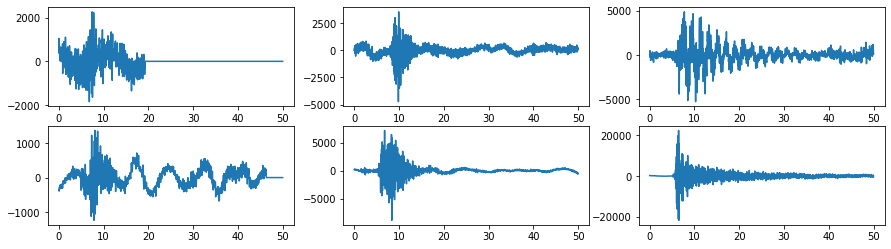

In [ ]:
# Quitando los valores NaN de los array numpy

# Señales VT
d_train_1[np.isnan(d_train_1)] = 0.0
d_test_1[np.isnan(d_test_1)] = 0.0
print(d_train_1.shape)
print(d_test_1.shape)

# Señales LP
d_train_2[np.isnan(d_train_2)] = 0.0
d_test_2[np.isnan(d_test_2)] = 0.0
print(d_train_2.shape)
print(d_test_2.shape)

# Señales Tor`
d_train_3[np.isnan(d_train_3)] = 0.0
d_test_3[np.isnan(d_test_3)] = 0.0
print(d_train_3.shape)
print(d_test_3.shape)

# Graficando
plt.figure(2, figsize=(15, 4))
plt.subplot(231)
plt.plot(t, d_train_1[60])
plt.subplot(232)
plt.plot(t, d_train_2[18])
plt.subplot(233)
plt.plot(t, d_train_3[38])
plt.subplot(234)
plt.plot(t, d_test_1[44])
plt.subplot(235)
plt.plot(t, d_test_2[34])
plt.subplot(236)
plt.plot(t, d_test_3[4])

# **P C A**

In [ ]:
from sklearn.decomposition import PCA
# concatentando los datos de entrenamiento y teste para calcular los PCA
VT = np.concatenate([d_train_1,d_test_1], axis=0)
LP = np.concatenate([d_train_2,d_test_2], axis=0)
Tor = np.concatenate([d_train_3,d_test_3], axis=0)

pca = PCA(n_components=0.95)
VT_pca = pca.fit_transform(VT)
LP_pca = pca.fit_transform(LP)
Tor_pca = pca.fit_transform(Tor)

print(d_train_1.shape, d_test_1.shape, VT.shape, VT_pca.shape)
print(d_train_2.shape, d_test_2.shape, LP.shape, LP_pca.shape)
print(d_train_3.shape, d_test_3.shape, Tor.shape, Tor_pca.shape)

(1480, 3000) (256, 3000) (1736, 3000) (1736, 6)
(362, 3000) (40, 3000) (402, 3000) (402, 84)
(61, 3000) (6, 3000) (67, 3000) (67, 31)


In [ ]:
sismos = np.concatenate([VT, LP, Tor], axis=0)
pca = PCA(n_components=0.95)
sismos_pca = pca.fit_transform(sismos)
print(sismos.shape, sismos_pca.shape)

(2205, 3000) (2205, 7)


Calculando 67 PCA para todos los datos de entrenamiento y prueba (67 que es la
cantidad de ejemplos que se tienen para una de las clases).


In [ ]:
pca = PCA(n_components=50)
vt_pc = pca.fit_transform(VT)
lp_pc = pca.fit_transform(LP)
tor_pc = pca.fit_transform(Tor)
print(vt_pc.shape, lp_pc.shape, tor_pc.shape)

(1736, 50) (402, 50) (67, 50)


Volvemos a separa el set de datos en set de entrenamiento y set de prueba para su
respectiva normalización.

In [ ]:
d_train_1, d_test_1 = vt_pc[0:1480 :], vt_pc[1480:1737, :]
d_train_2, d_test_2 = lp_pc[0:362 :], lp_pc[361:403, :]
d_train_3, d_test_3 = tor_pc[0:61 :], tor_pc[61:68, :]

print(d_train_1.shape, d_test_1.shape)
print(d_train_2.shape, d_test_2.shape)
print(d_train_3.shape, d_test_3.shape)

(1480, 50) (256, 50)
(362, 50) (41, 50)
(61, 50) (6, 50)


# **Normalización**

Mínimo y máximo originales: -2600460.4, 18090713.4
Mínimo y máximo normalizado: 0.0, 1.0
Mínimo y máximo originales: -304042.3, 1018660.3
Mínimo y máximo normalizado: 0.0, 1.0
Mínimo y máximo originales: -85848.7, 232894.7
Mínimo y máximo normalizado: 0.0, 1.0


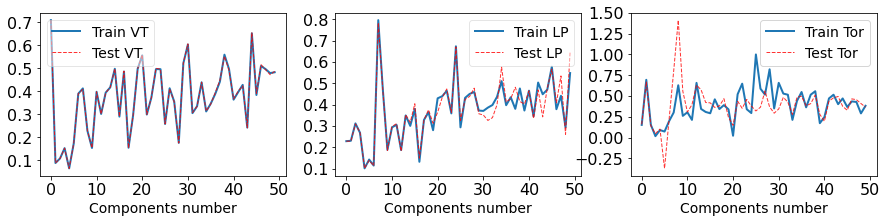

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

# Señales VT
D_train_s1 = min_max_scaler.fit_transform(d_train_1)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(d_train_1), np.max(d_train_1)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s1), np.max(D_train_s1)))
D_test_s1 = min_max_scaler.transform(d_test_1)

# Señales LP
D_train_s2 = min_max_scaler.fit_transform(d_train_2)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(d_train_2), np.max(d_train_2)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s2), np.max(D_train_s2)))
D_test_s2 = min_max_scaler.transform(d_test_2)

# Señales Tor
D_train_s3 = min_max_scaler.fit_transform(d_train_3)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(d_train_3), np.max(d_train_3)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s3), np.max(D_train_s3)))
D_test_s3 = min_max_scaler.transform(d_test_3) 

# Graficando
plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.plot(D_train_s1[60], lw=2, label="Train VT")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.subplot(132)
plt.plot(D_train_s2[18], lw=2, label="Train LP")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.subplot(133) 
plt.plot(D_train_s3[38], lw=2, label="Train Tor")
plt.legend(fontsize='14')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)



plt.subplot(131)
plt.plot(D_test_s1[44], 'r--', alpha=0.8, lw=1, label="Test VT")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xlabel('Components number', fontsize='14')
plt.subplot(132)
plt.plot(D_test_s2[34], 'r--', alpha=0.8, lw=1, label="Test LP")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xlabel('Components number', fontsize='14')
plt.subplot(133)
plt.plot(D_test_s3[4], 'r--', alpha=0.8, lw=1, label="Test Tor")
plt.legend(fontsize='14')
plt.xlabel('Components number', fontsize='14')

plt.savefig('caracter_PCA.pdf', dpi=400, format='pdf')

# **Clasificación con MLPerceptron**

Preparando los datos para ser presentados en el clasificador

In [ ]:
# a continuación son adicionadas tres columnas que me permitirán ser usadas
D_train_s1 = np.insert(D_train_s1, [0], (1,0,0), axis=1)
D_test_s1 = np.insert(D_test_s1, [0], (1,0,0), axis=1)
D_train_s2 = np.insert(D_train_s2, [0], (0,1,0), axis=1)
D_test_s2 = np.insert(D_test_s2, [0], (0,1,0), axis=1)
D_train_s3 = np.insert(D_train_s3, [0], (0,0,1), axis=1)
D_test_s3 = np.insert(D_test_s3, [0], (0,0,1), axis=1)

print(D_train_s1[1,0:5], D_test_s1[1,0:5])
print(D_train_s2[1,0:5], D_test_s2[1,0:5])
print(D_train_s3[1,0:5], D_test_s3[1,0:5])
print(D_train_s1[1,0:5], D_test_s1[1,0:5])
print(D_train_s2[1,0:5], D_test_s2[1,0:5])
print(D_train_s3[1,0:5], D_test_s3[1,0:5])

# Creo mi set de entrenamiento con sismos y sus etiquetas correspondientes y
set_train = np.concatenate([D_train_s1,D_train_s2, D_train_s3], axis=0)
set_test = np.concatenate([D_test_s1,D_test_s2, D_test_s3], axis=0)
y_vector = np.concatenate([set_train, set_test])
y_vector = y_vector[:,0:3]

# le doy una mezcla a los datos para que entren en desorden en la red neuron
np.random.shuffle(set_train)
np.random.shuffle(set_test)

print(set_train.shape, set_test.shape)

[1.         0.         0.         0.70926998 0.08769767] [1.         0.         0.         0.70930351 0.08773183]
[0.         1.         0.         0.22917182 0.23089353] [0.         1.         0.         0.22849763 0.22968349]
[0.         0.         1.         0.14981517 0.66598995] [0.         0.         1.         0.1602789  0.66023212]
[1.         0.         0.         0.70926998 0.08769767] [1.         0.         0.         0.70930351 0.08773183]
[0.         1.         0.         0.22917182 0.23089353] [0.         1.         0.         0.22849763 0.22968349]
[0.         0.         1.         0.14981517 0.66598995] [0.         0.         1.         0.1602789  0.66023212]
(1903, 53) (303, 53)


In [ ]:
print(set_train.shape, set_test.shape)
y_train, X_train = set_train[:,0:3], np.delete(set_train, range(0, 3), axis=1)
y_test, X_test = set_test[:,0:3], np.delete(set_test, range(0, 3), axis=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(y_train[1,0:5], X_train[1,0:5])
print(y_test[1,0:5], X_test[1,0:5])

X = np.concatenate([X_train,X_test], axis=0) 
y = np.concatenate([y_train,y_test], axis=0) 
print(X.shape, y.shape)

(1903, 53) (303, 53)
(1903, 50) (1903, 3) (303, 50) (303, 3)
[1. 0. 0.] [0.70906181 0.08771547 0.10762031 0.15227265 0.06437626]
[1. 0. 0.] [0.70919358 0.08771694 0.10765889 0.15229929 0.0645643 ]
(2206, 50) (2206, 3)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import Sequential
from keras.regularizers import l2 # cuando hay sobreajuste la regularización
# a decartar valores altos en la función de costo. Se puede colocar en cualq
from keras.layers import Dropout #apagar aleatoriamente algunas neuronas,
# ayudando a eliminar el sobreajuste
from keras.callbacks import EarlyStopping

Entrenamos un MLP para clasificar tres clases de sismos

In [ ]:
#np.random.seed(23)

dim_entrada = X_train.shape[1]
entrada = Input(shape=(dim_entrada,))

print(X_train.shape[1])
x = Dense(500, activation='relu', kernel_regularizer=l2(0.005))(entrada)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.25)(x)
saida = Dense(3, activation='softmax')(x)
clasificador = Model(inputs=entrada, outputs=saida)
clasificador.summary()

50
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 500)               25500     
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 75,903
Trainable params: 75,903
Non-trainabl

In [ ]:
y_label = []
for i in range(len(y)):
  if y[i,0] > 0:
    y_label.append(0)
  if y[i,1] > 0:
    y_label.append(1)
  if y[i,2] > 0:
    y_label.append(2)
y_label = np.array(y_label)
print(y_label.shape)

(2206,)


# Implementando Validación Cruzada Estratificada y Clasificación

In [ ]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

Definimos la configuracipon de Validacipon Cruzada estratificada y luego el modelo de clasificación:

In [ ]:
cv = StratifiedShuffleSplit(n_splits=6, random_state=True)

clasificador = Model(inputs=entrada, outputs=saida)

# Aplicando CrossValidation en los datos PCA

StratifiedShuffleSplit(n_splits=6, random_state=True, test_size=None,
            train_size=None)
TRAIN: [ 312 1624  432 ...  247   22  564] TEST: [ 784 1054 1948  263 1834  426 1203 1451  335 1684  234  852 2153  442
 1729  211 1422  773 1350 1753  630 1820 1757 1340 1467 1178  618 2144
  425  373 1288 1413 2041 1490 1622 1122 1224 1442  464  557 1158 1977
  646 1823 1588  325  834 1094  283 2066  132 1716 2110   34 1553 1771
 1237  287 1361 1399  830  194  931  741 1414  529  652  430  123 1696
  971 1811 1192  208 1362  158 1092 1114 1337 2057 2050  766 1175 1572
  810  230  759 2056 1653  374 1687 1292  197 2040 2137 1208 1581 1657
 1901  290  575  178 1376 1505  361 1428 1347 2197  906 1950 2106 1263
  674 1921  874 1569 1831    3  979  869  567 1152 1143  485 2133 1916
 1423  543 1795 1164  624 1382 1709 2011  825  625 1956  315 1739 1440
 1512 1857  948 1761 1896 1998 2198  739 1929  973  534  824 1301 1550
  919  349 2063 1779 2008  969  179 2028 1604  204  421  702 1069 1195


TRAIN: [1272 1751  557 ... 1073 1033  912] TEST: [1067  590  524 1006  768  814 1744  889 2170 1141   50  957  992 1288
  282  432 1146 2099 1345 1967 1352  951  862 1766 2001  110  781  285
  529 2038  308  434 1830 1569 1425 1158   46  512  801 1416 1733 1100
 2160  655  143 1402  101  977 1281 1517 1038   38  628  541 1436  117
 1461 1051   82 1707  401  564  780  329  224 1673 1410 1505  821  759
 1470 1486 1453  258 2033 1802  774 2199 1096 1944  452 1966 1578 2024
  864 1216 1896  791 1373  819 1399 1063 2028  470 1682 2138 1773 1784
 1912  362 2128  489 2004  817  109  165  305  381   99  341  356 2133
  675 1451  354  546 1160 1036 1538 1075 1843  915  138  638  617  163
  946 1351 1460 1458 1501  264 1887 1750 1368 1320  527 1499 1336   70
 1189  758   17 1154 1951  651  122 1726  980  261 1237 1350 1819 2145
  182 1792 2187 1643 1880 1942  866  486 1249 1263  553 1648 1812 1256
 1872  531  304 1801  254  672 1664 1592 1978 2125 1366 1452  301  837
 1421 1149  272 1254 1482 14

TRAIN: [  89   40  295 ...  377 1382 1400] TEST: [1373 1073  591 1864 2180  315 1794  512  288 1021  324 2100  574 1919
  799  957  707 1495  272  371  281  162  221 2019  879 2157 1466  820
  961  419 2025  141 1479 1398 1742  285 2192  907 1299 1204 1653  382
 1226 1121 2006  519 2097 1904   74 2021  381   33 1674 2188 1138  359
 2163 2003 2193  168  518 1395  771  207 1491 1257  220 1525 1166 1737
  334 1504 1192 1159 1949  480  422  767 1321 1779 1502 1347  271 1859
  542 1161 1709 1083 1114 2013 1807   98 1130 1766  932 2196  111 1378
  981 1615 1055  668 2183 1872 1358 2058 2010 2160  372  309 2079  952
 1626  715  343  227 2061  280 1557  442  808  874 1397 1119 2087  803
 1613  383  998  395 1741  749  750 1736 1896  761 1787 1603 1800 1198
 1245  809 1569  453 2146 1944 1676  170  954  964 1545  121 2020  913
 1345  607 1735  985 1551  708 1544 2096 1205 2078  833 1585 1110  264
 1683 1434  991   76  436  557 1824  553 1596  214 2119 1628 1233 1275
  299 2080  851  735  326  8

TRAIN: [1458  218 1447 ... 1570  586 1801] TEST: [2034  930  523  583  214   47  810  632 1173  578 2090   71  283 1625
  279 1726  799  794  540  645  920 1166  648  477  408   23   95 1615
 1192 1693  649 1847 1667 1858 1102 1066  223  803 1829 1215  703 2180
 2138 1433 1624 1979 1629  940 1968  359 2125 1800 2002 2074  975 1139
  565 1553  402 1684  490  714 2120 1889 2149 2008  686  324  378 2129
 1504 1075 1808 1529  380 1530  155 1406 1015 2130  792 1937 1479   35
  496   86 1002  549  809  626 2141 1463  550  379  131 1168 1020 1718
 1807  142 1663 1115 1412  167  691 1537  224  143  336  363 1003  843
 1117  539  935  139  375  758  615 1588 1368 1843 2051 1162  104 2175
 1516  814 1742  381 1887  895 1732 1294 1686 1087 1743 1893 1090  886
 1287 1203 1127 1842 1132 1857 1711  755   43 2137  193 1148 1768  217
 1184 1337 1181  790 1234  192 1167  732  971  569 1274 1790 2155 1278
 1914  153 2098 2151 1033 1809 1061  806  718 2075 2033  754 1690 1034
 1405 1258 2128 1408    6  7

TRAIN: [2192  535 1143 ... 1269 1729 1764] TEST: [  15 1463  335 1658  590 1086 1011 1342  667   25  912 1233 1790 1208
  138  778  857  498 1687 1851  777 1121 1864   39 1061  614 1015 1306
  125  632 2008  786 1731 1784  227  126  656  152 2030 1105 2004  127
 1063 1128  798 1504 1590 1314  829 1229 1239 2038 1076  252  830 1377
  675  732  464 1009  967  594  446 1220 1706  392 1378 1624 1944  505
 1489 1319 1322  373 1792 1154 1272  714  142  231  343 2049 2020  295
 1387  156 2064 1444  512 1255 1519  144  793 1856    8  215  960  803
  642  916 1905  611  477  402  157 1217  655 1666 1939 1016 1645 1046
  553 1165 1696 1553 1278  843 1196 2080  302 1911  527  397 1283 1772
 1003 1027 1526 1642 1368 2000 1354 2179  852 1903  421  520  451 1701
 1285 1035 2060 1058 2003   51 1775  576 2069  419 1129  682 1151 1659
 1007  246  399  884    6 1735  291  210 1439 1328  971  185 1766  391
   10 1937 1147  588 1472 1476 1059 2024 1227  844  224  460 1153 1887
  232 1189  403  313  556  2

TRAIN: [ 438  290  357 ...  469 1110  435] TEST: [ 676  859  563 2059  400  986  186 1081 1090  636 1236  176 1536 1285
 2005 1591  282 1248 2135  367 1968  616  449 1061  242 1310  942  679
  277    2  433  506 1667 1637 1859  558  866 2193  621 1502 1466 1100
  839  976  451 2199  538 1120 1371   55   32 1888   16  675  645 1227
 1937 1866  431  348  111 1553 1188 1546 1016 2067 1408   62  586 1710
  749 1543 1672  782 1003 1768  624 1756 1220 1312  295  716  169 2072
 1727  123  772 1676 1788 2080 1755  136  313 1322  380 1585 1315  654
    6  561  154  937 2010 1620  113  732  201  430  479 1920   53  388
 1943 1559 2077 2046 1391  378  177  933   89 1596  333  133 1678 2093
 1929 2190  489 1600 1307 1009 1527  237 1834  125  776 1579  951 2002
 1896 1566 1674 1321  969 1004  140  812  960 1127 1832  369 1250 1744
 1619  472 2107  959 1140 2018 1185  900  519 2155 1607 1496  102 1156
  877   30 1924 1771 1363  341 1245 1037  456  741 1050 1043 1422 1529
  640 1833 1203 1879 1782 10

train -  [1562  363   60]   |   test -  [174  40   7]
train -  [1562  363   60]   |   test -  [174  40   7]
train -  [1562  363   60]   |   test -  [174  40   7]
train -  [1562  363   60]   |   test -  [174  40   7]
train -  [1562  363   60]   |   test -  [174  40   7]
train -  [1562  363   60]   |   test -  [174  40   7]


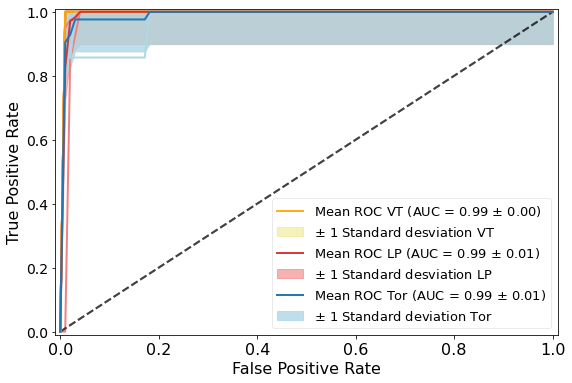

<Figure size 432x432 with 0 Axes>

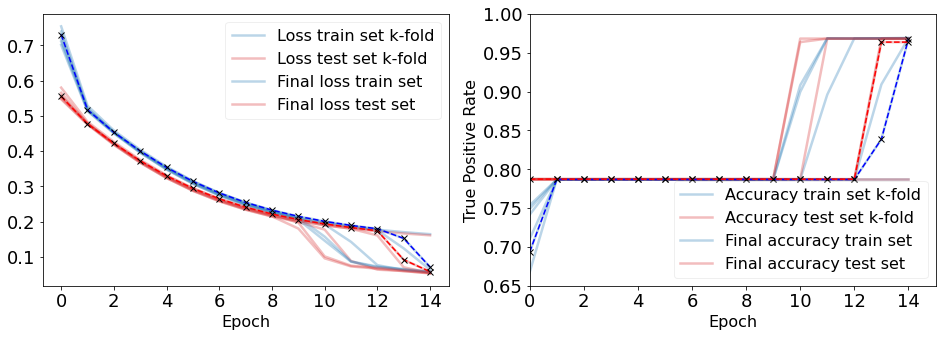

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#cv.get_n_splits(X, y_label)

print(cv)
StratifiedShuffleSplit(n_splits=6, random_state=True)

fig, ax = plt.subplots(1, figsize = (9, 6))
tprs_mean_0 = []
tprs_mean_1 = []
tprs_mean_2 = []
aucs_0 = []
aucs_1 = []
aucs_2 = []
fold = 1

for train_index, test_index in cv.split(X, y_label):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  

  dim_entrada = X.shape[1]      
  entrada = Input(shape=(dim_entrada,))
  x = Dense(500, activation='relu', kernel_regularizer=l2(0.005))(entrada)
  x = Dropout(0.25)(x)
  x = Dense(100, activation='relu')(x)
  x = Dropout(0.25)(x)
  saida = Dense(3, activation='softmax')(x)

  
  clasificador = Model(inputs=entrada, outputs=saida)
  clasificador.compile(optimizer='adam', loss='mae', metrics=['categorical_accuracy'])
  historia = clasificador.fit(X_train, y_train,    
                           epochs=15,
                           batch_size=250,
                           validation_data=(X_test, y_test),    
                           shuffle=True)
  
  print("ENTRENAMIENTO EN EL FOLD %0.2f" %(fold))
  y_pred = clasificador.predict(X_test)
  
  tprs = []
  Corte = []
  
  base_fpr = np.linspace(0, 1, 101)
  mean_fpr = np.linspace(0, 1, 100)


  #Curva ROC para la clase VT

  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 0],  y_pred[:,0])
    auc1 = roc_auc_score(y_test[:, 0], y_pred[:, 0])   # Es auc1, o deberia ser auc0????????  no importa porque luego forma un vector para cada tipo de sismo

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_0.append(auc1)

  Corte.append(th[np.argmax(tpr - fpr)])
  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k",  
          alpha=0.2)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="orange",
      lw=2,
      alpha=0.9,
  )
  tprs_mean_0.append(mean_tpr)

  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.ylabel('True Positive Rate', fontsize=16)
  plt.xlabel('False Positive Rate', fontsize=16)


  #Curva ROC para la clase LP

  tprs = []
  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 1],  y_pred[:, 1])
    auc1 = roc_auc_score(y_test[:, 1], y_pred[:, 1])

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_1.append(auc1)

  Corte.append(th[np.argmax(tpr - fpr)])

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="lightcoral",
      lw=2,
      alpha=0.99, # alpha es transparencia 
  )
  tprs_mean_1.append(mean_tpr)

  #Curva ROC para la clase Tor
  
  tprs = []
  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 2],  y_pred[:, 2])
    auc1 = roc_auc_score(y_test[:, 2], y_pred[:, 2])    # Es auc1, o deberia ser auc0????????  no importa porque luego forma un vector para cada tipo de sismo

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_2.append(auc1)

  Corte.append(th[np.argmax(tpr - fpr)])

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="lightblue",
      lw=2,
  )
 
  tprs_mean_2.append(mean_tpr)
  ax.legend(loc="lower right",fontsize = 8)
  plt.xticks(fontsize=16), plt.yticks(fontsize=14)


  import matplotlib.pyplot as plt
  plt.figure(5, figsize=(16,5))
  plt.subplot(1,2,1)
  plt.plot(historia.history["loss"], color = 'tab:blue', alpha = 0.3, lw = 2.5)   #label="Pérdida train (Fold %0.2f)" %(fold)
  plt.plot(historia.history["val_loss"], color = 'tab:red', alpha = 0.3, lw = 2.5)
  plt.subplot(1,2,2)
  plt.plot(historia.history["categorical_accuracy"], color = 'tab:blue', alpha = 0.3, lw = 2.5)
  plt.plot(historia.history["val_categorical_accuracy"], color = 'tab:red', alpha = 0.3, lw = 2.5)
  
  fold = fold + 1  

for train, test in cv.split(X, y_label):
  print('train -  {}   |   test -  {}'.format(
      np.bincount(y_label[train]), np.bincount(y_label[test])))

plt.figure(3, figsize=(6,6))
tpr_0_final = np.mean(tprs_mean_0, axis=0)
std_tpr_0 = np.std(tpr_0_final, axis=0)
tprs_upper_0 = np.minimum(tpr_0_final + std_tpr_0, 1)
tprs_lower_0 = np.maximum(tpr_0_final - std_tpr_0, 0)

tpr_0_final[-1] = 1.0
mean_auc_0 = auc(mean_fpr, tpr_0_final)
std_auc_0 = np.std(aucs_0)
ax.plot(
    mean_fpr,
    tpr_0_final,
    color="orange",
    label=r"Mean ROC VT (AUC = %0.2f $\pm$ %0.2f)" %(mean_auc_0, std_auc_0),
    lw=2,
    alpha=0.9,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_0,
    tprs_upper_0,
    color="khaki",
    alpha=0.6,
    label="$\pm$ 1 Standard desviation VT",
)

tpr_1_final = np.mean(tprs_mean_1, axis=0)
std_tpr_1 = np.std(tpr_1_final, axis=0)
tprs_upper_1 = np.minimum(tpr_1_final + std_tpr_1, 1)
tprs_lower_1 = np.maximum(tpr_1_final - std_tpr_1, 0)

tpr_1_final[-1] = 1.0
mean_auc_1 = auc(mean_fpr, tpr_0_final)
std_auc_1 = np.std(aucs_1)
ax.plot(
    mean_fpr,
    tpr_1_final,
    color="tab:red",
    label=r"Mean ROC LP (AUC = %0.2f $\pm$ %0.2f)" %(mean_auc_1, std_auc_1),
    lw=2,
    alpha=0.9,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_1,
    tprs_upper_1,
    color="lightcoral",
    alpha=0.6,
    label="$\pm$ 1 Standard desviation LP",
)

tpr_2_final = np.mean(tprs_mean_2, axis=0)
std_tpr_2 = np.std(tpr_2_final, axis=0)
tprs_upper_2 = np.minimum(tpr_2_final + std_tpr_2, 1)
tprs_lower_2 = np.maximum(tpr_2_final - std_tpr_2, 0)

tpr_2_final[-1] = 1.0
mean_auc_2 = auc(mean_fpr, tpr_2_final)
std_auc_2 = np.std(aucs_2)
ax.plot(
    mean_fpr,
    tpr_2_final,
    color="tab:blue",
    label=r"Mean ROC Tor (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc_2, std_auc_2),
    lw=2,
    alpha=0.99,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_2,
    tprs_upper_2,
    color="lightblue",
    alpha=0.8,
    label=r"$\pm$ 1 Standard deviation Tor",
)

ax.legend(loc="lower right",fontsize = 13, fancybox=True, framealpha=0.4)

ax.figure.savefig('ROC_PCA3.pdf', dpi=400, format='pdf')


plt.figure(5, figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], 'xb--',mec='k', lw=1.5) 
plt.plot(historia.history["val_loss"], 'xr--',mec='k', lw=1.5) 
plt.xlabel('Epoch', fontsize=16)
plt.xticks(fontsize=18), plt.yticks(fontsize=18)
plt.legend(labels=["Loss train set k-fold", 
                   "Loss test set k-fold",
                   "Final loss train set", 
                   "Final loss test set"], 
           fontsize='16', fancybox=True, framealpha=0.3)
plt.subplot(1,2,2)
plt.plot(historia.history["categorical_accuracy"], 'xb--',mec='k', lw=1.5) 
plt.plot(historia.history["val_categorical_accuracy"], 'xr--',mec='k', lw=1.5) 
plt.xlim(0, 15)
plt.ylim(0.65, 1.0)
plt.xlabel('Epoch', fontsize=16)
plt.legend(labels=["Accuracy train set k-fold", 
                   "Accuracy test set k-fold",
                   "Final accuracy train set", 
                   "Final accuracy test set"], 
           fontsize='16', fancybox=True, loc='lower right', framealpha=0.3) 
plt.xticks(fontsize=18), plt.yticks(fontsize=18)

plt.savefig('CrossVall_PCA.pdf', dpi=400, format='pdf')

**Matriz de Confusión**

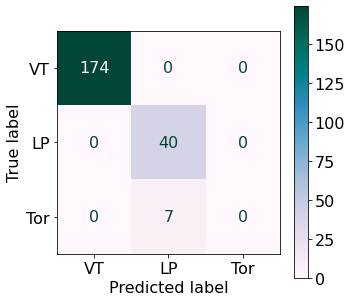

[[[ 47   0]
  [  0 174]]

 [[174   7]
  [  0  40]]

 [[214   0]
  [  7   0]]]
matriz VT  [[ 47   0]
 [  0 174]]
matriz LP  [[174   7]
 [  0  40]]
matriz Tor  [[214   0]
 [  7   0]]


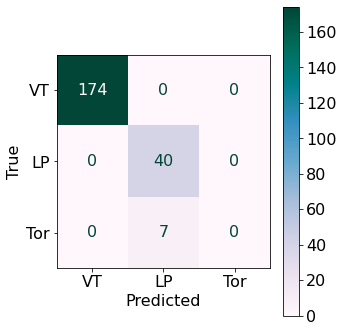

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

y_pred_ = np.rint(y_pred)
y_salida = []
for i in range(len(y_pred)):
  if y_pred_[i,0] > 0:
    y_salida.append('VT')
  if y_pred_[i,1] > 0:
    y_salida.append('LP')
  if y_pred_[i,2] > 0:
    y_salida.append('Tor') 


y_true = []
for i in range(len(y_test)):
  if y_test[i,0] > 0:
    y_true.append('VT')
  if y_test[i,1] > 0:
    y_true.append('LP')
  if y_test[i,2] > 0:
    y_true.append('Tor')

c = confusion_matrix (y_true , y_salida , labels = ["VT", "LP", "Tor"] , sample_weight = None)
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=["VT", "LP", "Tor"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('True', fontsize=16)
# ax.set_title('Confusion Matrix', fontsize=18)
plt.tight_layout()
plt.savefig('confusion_matrix.pdf', dpi=400, format='pdf')

plt.rcParams.update({'font.size': 16})

cm = multilabel_confusion_matrix(y_true, y_salida, labels=["VT", "LP", "Tor"])
print(cm)
cmVT = cm[0]
cmLP = cm[1]
cmTor = cm[2]
print('matriz VT ', cmVT)
print('matriz LP ', cmLP)
print('matriz Tor ', cmTor)

# **Evaluación con Métricas de Desempeño**

In [ ]:
def calcular_sensitividad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FN = CM[1,0]
  sen = 100*(TP/(TP+FN))
  print('Sensitividad ' + clase_sismo + ': {:.1f}%'.format(sen))
  return sen


def calcular_especificidad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TN = CM[0,0]
  FP = CM[0,1]
  esp = 100*(TN/(TN+FP))
  print('Especificidad ' + clase_sismo + ': {:.1f}%'.format(esp))
  return esp


def calcular_precision(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FP = CM[0,1]
  pres = 100*(TP/(TP+FP))
  print('Precisión ' + clase_sismo + ': {:.1f}%'.format(pres))
  return pres


def calcular_f1(sencitividad, precision, clase_sismo):
  f1 = 2*(precision*sencitividad)/(precision+sencitividad)
  print('f1 score ' + clase_sismo + ': {:.1f}%'.format(f1))
  return f1

In [ ]:
# Calculo de Especificidad
esp_1 = calcular_especificidad('VT')
esp_2 = calcular_especificidad('LP')
esp_3 = calcular_especificidad('Tor')
# Cálculo de Sensitividad
sen_1 = calcular_sensitividad('VT')
sen_2 = calcular_sensitividad('LP')
sen_3 = calcular_sensitividad('Tor')
# Cálculo de Precisión
pres_1 = calcular_precision('VT')
pres_2 = calcular_precision('LP')
pres_3 = calcular_precision('Tor')
# Cálculo de f1 score
f1_1 = calcular_f1(sen_1,pres_1,'VT')
f1_2 = calcular_f1(sen_2,pres_2,'LP')
f1_3 = calcular_f1(sen_3,pres_3,'Tor')

Especificidad VT: 100.0%
Especificidad LP: 95.6%
Especificidad Tor: 100.0%
Sensitividad VT: 99.4%
Sensitividad LP: 100.0%
Sensitividad Tor: 0.0%
Precisión VT: 100.0%
Precisión LP: 83.3%
Precisión Tor: nan%
f1 score VT: 99.7%
f1 score LP: 90.9%
f1 score Tor: nan%


<ipython-input-19-d14efc6aa696>:38: RuntimeWarning: invalid value encountered in long_scalars
  pres = 100*(TP/(TP+FP))


In [ ]:
from sklearn.metrics import classification_report
# y_pred_label, y_test_label
target_names = ['VT', 'LP', 'Tor']
print(classification_report(y_test, y_pred_, target_names=target_names))

              precision    recall  f1-score   support

          VT       1.00      0.99      1.00       174
          LP       0.83      1.00      0.91        40
         Tor       0.00      0.00      0.00         7

   micro avg       0.96      0.96      0.96       221
   macro avg       0.61      0.66      0.64       221
weighted avg       0.94      0.96      0.95       221
 samples avg       0.96      0.96      0.96       221



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clasificador = Model(inputs=entrada, outputs=saida)
clasificador.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
historia = clasificador.fit(X_train, y_train,
 epochs=15,
 batch_size=150,
 validation_data=(X_test, y_test),
 shuffle=True)

Epoch 1/15
13/13 [==============================] - 1s 27ms/step - loss: 0.6556 - accuracy: 0.7378 - val_loss: 0.4612 - val_accuracy: 0.8449
Epoch 2/15
13/13 [==============================] - 0s 11ms/step - loss: 0.4623 - accuracy: 0.7777 - val_loss: 0.3674 - val_accuracy: 0.8449
Epoch 3/15
13/13 [==============================] - 0s 9ms/step - loss: 0.3767 - accuracy: 0.7777 - val_loss: 0.2922 - val_accuracy: 0.8449
Epoch 4/15
13/13 [==============================] - 0s 10ms/step - loss: 0.3102 - accuracy: 0.7777 - val_loss: 0.2361 - val_accuracy: 0.8449
Epoch 5/15
13/13 [==============================] - 0s 10ms/step - loss: 0.2617 - accuracy: 0.7777 - val_loss: 0.1960 - val_accuracy: 0.8449
Epoch 6/15
13/13 [==============================] - 0s 12ms/step - loss: 0.2275 - accuracy: 0.7777 - val_loss: 0.1682 - val_accuracy: 0.8449
Epoch 7/15
13/13 [==============================] - 0s 11ms/step - loss: 0.2037 - accuracy: 0.7777 - val_loss: 0.1488 - val_accuracy: 0.8449
Epoch 8/15
13/

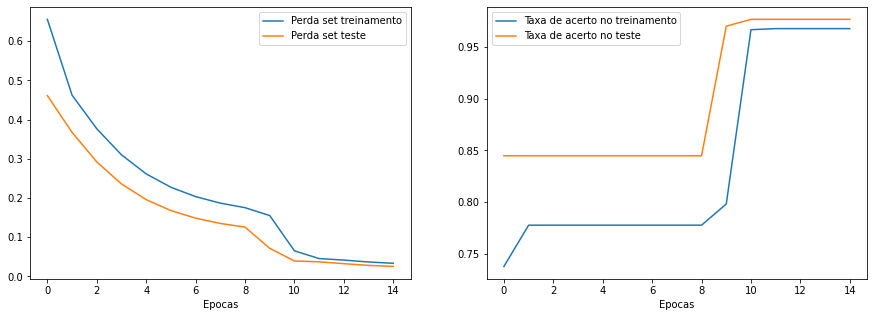

In [ ]:
import matplotlib.pyplot as plt
plt.figure(5, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], label="Perda set treinamento")
plt.plot(historia.history["val_loss"], label="Perda set teste")
plt.xlabel('Epocas')
plt.legend()
plt.subplot(1,2,2)
plt.plot(historia.history["accuracy"], label="Taxa de acerto no treinamento")
plt.plot(historia.history["val_accuracy"], label="Taxa de acerto no teste")
plt.xlabel('Epocas')
plt.legend()

10/10 [==============================] - 0s 3ms/step


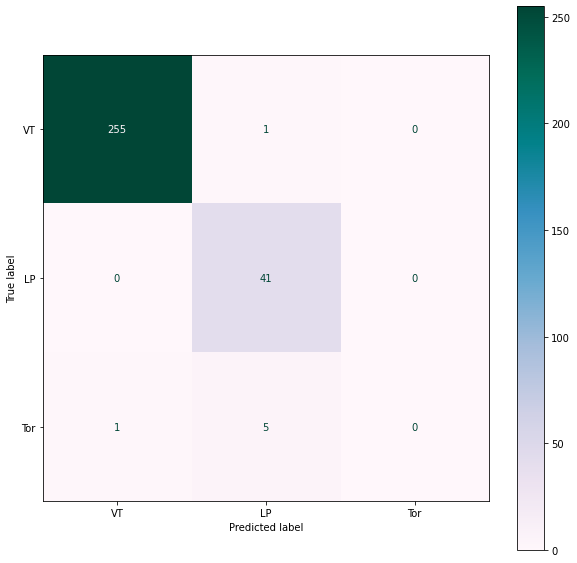

[[[ 46   1]
  [  1 255]]

 [[256   6]
  [  0  41]]

 [[297   0]
  [  6   0]]]
matriz VT  [[ 46   1]
 [  1 255]]
matriz LP  [[256   6]
 [  0  41]]
matriz Tor  [[297   0]
 [  6   0]]


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

clasificador = Model(inputs=entrada, outputs=saida)
y_pred = clasificador.predict(X_test)
y_pred_ = np.rint(y_pred)

y_true = []
for i in range(len(y_test)):
  if y_test[i,0] > 0:
    y_true.append('VT')
  if y_test[i,1] > 0:
    y_true.append('LP')
  if y_test[i,2] > 0:
    y_true.append('Tor')

y_salida = []
for i in range(len(y_pred_)):
  if y_pred_[i,0] > 0:
    y_salida.append('VT')
  if y_pred_[i,1] > 0:
    y_salida.append('LP')
  if y_pred_[i,2] > 0:
    y_salida.append('Tor') 

# Matriz de confusión multiclase
c = confusion_matrix ( y_true , y_salida , labels = ["VT", "LP", "Tor"] , sample_weight = None)
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=["VT", "LP", "Tor"])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
plt.show()
plt.show()
cm = multilabel_confusion_matrix(y_true, y_salida, labels=["VT", "LP", "Tor"])
print(cm)
cmVT = cm[0]
cmLP = cm[1]
cmTor = cm[2]
print('matriz VT ', cmVT)
print('matriz LP ', cmLP)
print('matriz Tor ', cmTor)

**Sensitividad y Especificidad**


*   Verdaderos Positivos (TP): La clase de sismo de interés que ha sido clasificada
correctamente,

*   Falsos negativos (FN): La clase de sismo de interés que fue clasificada como otro
tipo de sismo


*   Verdadero negativo (TN): Otros tipo de sismo que fue correctamente clasificado
como un tipo de sismo diferente a la clase de interés, y

*   Falsos positivos (FP): cuando un sismo diferente fue clasificado como si fuera el
simo de la clase de interés.

La **sensitividad** mide la proporción de los sismos de interés detectados
correctamente, una sensitividad del 100% detectará todos los sismos de interés:

$$Sensitividad = \frac{TP}{TP+FN}$$

La **especificidad** mide la proporción de otro tipo de sismos que fueron detectados
correctamente diferentes a la clase de interés. Una especificidad del 100% detectará
sismos diferentes a la clase de interés:

$$Especificidad = \frac{TN}{TN+FP}$$

In [ ]:
def calcular_sensitividad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FN = CM[1,0]
  sen = 100*(TP/(TP+FN))
  print('Sensitividad ' + clase_sismo + ': {:.1f}%'.format(sen))
  return sen


def calcular_especificidad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TN = CM[0,0]
  FP = CM[0,1]
  esp = 100*(TN/(TN+FP))
  print('Especificidad ' + clase_sismo + ': {:.1f}%'.format(esp))
  return esp


def calcular_precision(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FP = CM[0,1]
  pres = 100*(TP/(TP+FP))
  print('Precisión ' + clase_sismo + ': {:.1f}%'.format(pres))
  return pres


def calcular_f1(sencitividad, precision, clase_sismo):
  f1 = 2*(precision*sencitividad)/(precision+sencitividad)
  print('f1 score ' + clase_sismo + ': {:.1f}%'.format(f1))
  return f1

In [ ]:
# Calculo de Especificidad
esp_1 = calcular_especificidad('VT')
esp_2 = calcular_especificidad('LP')
esp_3 = calcular_especificidad('Tor')
# Cálculo de Sensitividad
sen_1 = calcular_sensitividad('VT')
sen_2 = calcular_sensitividad('LP')
sen_3 = calcular_sensitividad('Tor')
# Cálculo de Precisión
pres_1 = calcular_precision('VT')
pres_2 = calcular_precision('LP')
pres_3 = calcular_precision('Tor')
# Cálculo de f1 score
f1_1 = calcular_f1(sen_1,pres_1,'VT')
f1_2 = calcular_f1(sen_2,pres_2,'LP')
f1_3 = calcular_f1(sen_3,pres_3,'Tor')

Especificidad VT: 97.9%
Especificidad LP: 97.7%
Especificidad Tor: 100.0%
Sensitividad VT: 99.6%
Sensitividad LP: 100.0%
Sensitividad Tor: 0.0%
Precisión VT: 99.6%
Precisión LP: 87.2%
Precisión Tor: nan%
f1 score VT: 99.6%
f1 score LP: 93.2%
f1 score Tor: nan%


<ipython-input-48-d14efc6aa696>:38: RuntimeWarning: invalid value encountered in long_scalars
  pres = 100*(TP/(TP+FP))


In [ ]:
from sklearn.metrics import classification_report
# y_pred_label, y_test_label
target_names = ['VT', 'LP', 'Tor']
print(classification_report(y_test, y_pred_, target_names=target_names))

              precision    recall  f1-score   support

          VT       1.00      1.00      1.00       256
          LP       0.87      1.00      0.93        41
         Tor       0.00      0.00      0.00         6

   micro avg       0.98      0.98      0.98       303
   macro avg       0.62      0.67      0.64       303
weighted avg       0.96      0.98      0.97       303
 samples avg       0.98      0.98      0.98       303



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3


for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 3

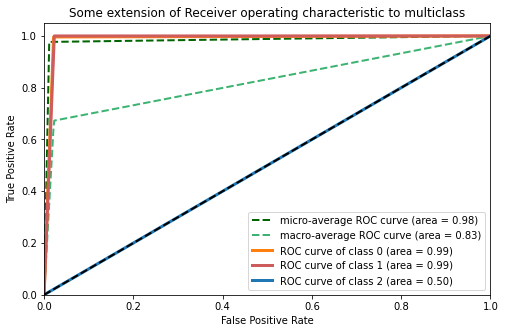

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,5))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="darkgreen", #deeppink
    linestyle="--",
    linewidth=2,
    )

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="mediumseagreen", #
    linestyle="--",
    linewidth=2,
    )

colors = cycle(["tab:orange", "indianred", "tab:blue"])
for i, color in zip(range(n_classes), colors):
  plt.plot(
      fpr[i],
      tpr[i],
      color=color,
      lw=lw,
      label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
   )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()                                                                 